In [16]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In this notebook, we show how to compute the kinetic energy and vorticity from the last time step of output.
# Define the non-dimensional numbers

In [15]:
U = .1
T = 5e5  # seconds
tau0 = .0001
dt = 5e-2
L = 5e4   # Rossby radius (50km)
Re4 = 1563.
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .004
ntime = 187

In [32]:
ds = xr.open_dataset('../psi000_10percent_lasttimestep.nc')
ds

FileNotFoundError: [Errno 2] No such file or directory: b'/home/uchidat/notebooks/msqg/psi000_10percent_lasttimestep.nc'

# Define functions to satisfy the lateral boundary conditions

In [12]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                  coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                          'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                 ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [9]:
psi_padded = xr.DataArray(pad_bc(ds.psi), 
                          dims=['nmemb','Z','Yp1','Xp1'],
                          coords={'nmemb':ds.nmemb.data,'Z':ds.Z.data,
                                  'Yp1':np.arange(-dx/2,L0+dx,dx),
                                  'Xp1':np.arange(-dx/2,L0+dx,dx)}
                         ).chunk({'nmemb':4,'Z':1,'Xp1':60,'Yp1':60})
psi_padded

,Array,Chunk
Bytes,80.68 MB,57.60 kB
Shape,"(101, 3, 258, 258)","(4, 1, 60, 60)"
Count,1950 Tasks,1950 Chunks
Type,float32,numpy.ndarray


# Calculate the horizontal velocities
$$u = -\frac{\partial\psi}{\partial y}, v = \frac{\partial\psi}{\partial x}$$

In [26]:
u = -psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
v = psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

In [27]:
KE = .25*xr.DataArray((u**2).isel(Yp1=slice(None,-1)).data 
                      + (u**2).isel(Yp1=slice(1,None)).data 
                      + (v**2).isel(Xp1=slice(None,-1)).data 
                      + (v**2).isel(Xp1=slice(None,-1)).data,
                      dims=ds.psi.dims, coords=ds.psi.coords
                     )
KE

,Array,Chunk
Bytes,79.43 MB,54.75 kB
Shape,"(101, 3, 256, 256)","(4, 1, 58, 59)"
Count,159588 Tasks,9126 Chunks
Type,float32,numpy.ndarray


# Relative vorticity
$$\zeta = \nabla_\text{h}^2 \psi$$

In [14]:
vort = laplacian(psi_padded, Delta=dx, padded=True, dim=['nmemb','Z','Yp1','Xp1'])
vort

,Array,Chunk
Bytes,79.43 MB,53.82 kB
Shape,"(101, 3, 256, 256)","(4, 1, 58, 58)"
Count,189228 Tasks,13182 Chunks
Type,float32,numpy.ndarray


# Plots
### The CTRL run

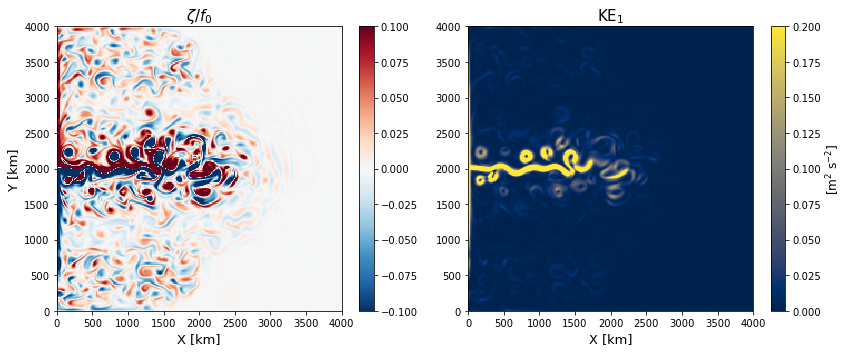

In [30]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
im1 = ax1.pcolormesh(ds.XC*L*1e-3, ds.YC*L*1e-3, vort.isel(nmemb=-1,Z=0) * Rom, 
                     cmap='RdBu_r', vmin=-.1, vmax=.1)
im2 = ax2.pcolormesh(ds.XC*L*1e-3, ds.YC*L*1e-3, KE.isel(nmemb=-1,Z=0) * U**2, 
                     cmap='cividis', vmin=0., vmax=0.2)
ax1.set_title(r"$\zeta/f_0$", fontsize=15)
ax2.set_title(r"KE$_1$", fontsize=15)
ax1.set_xlabel(r"X [km]", fontsize=13)
ax2.set_xlabel(r"X [km]", fontsize=13)
ax1.set_ylabel(r"Y [km]", fontsize=13)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)

### Ensemble mean

[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed | 18.7s


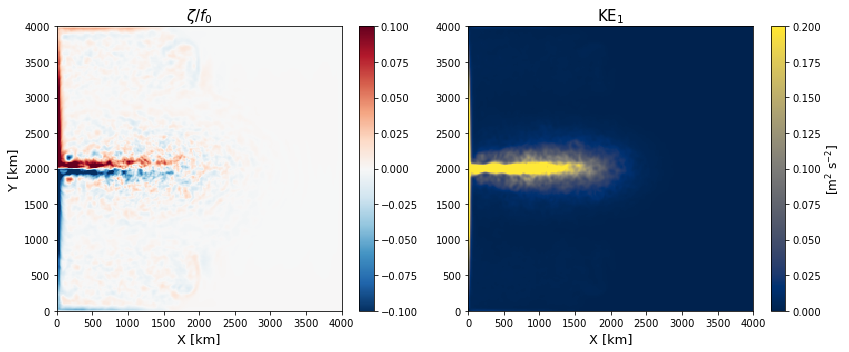

In [31]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
with ProgressBar():
    im1 = ax1.pcolormesh(ds.XC*L*1e-3, ds.YC*L*1e-3, vort.isel(Z=0).mean('nmemb') * Rom, 
                         cmap='RdBu_r', vmin=-.1, vmax=.1)
    im2 = ax2.pcolormesh(ds.XC*L*1e-3, ds.YC*L*1e-3, KE.isel(Z=0).mean('nmemb') * U**2, 
                         cmap='cividis', vmin=0., vmax=0.2)
ax1.set_title(r"$\zeta/f_0$", fontsize=15)
ax2.set_title(r"KE$_1$", fontsize=15)
ax1.set_xlabel(r"X [km]", fontsize=13)
ax2.set_xlabel(r"X [km]", fontsize=13)
ax1.set_ylabel(r"Y [km]", fontsize=13)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)